In [4]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import secrets
import contractions
import re
import seaborn as sns
import matplotlib.pyplot as plt
import lyricsgenius
from datetime import datetime
from collections import Counter
import spacy
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA, DEP, LEMMA, LOWER, IS_PUNCT, IS_DIGIT, IS_SPACE, IS_STOP
from spacy.tokens import Doc
import importlib
import string
import spacy_custom_ner_train as ner_train

In [6]:
ner_train.main(output_dir="/", )

Created blank 'en' model


TypeError: object of type 'NoneType' has no len()

In [2]:
genius = lyricsgenius.Genius(secrets.GENIUS_ACCESS_TOKEN)
# nlp = spacy.load("en_core_web_sm")
nlp = spacy.load("new_model")

In [3]:
def remove_tokens(doc, index_to_del, list_attr=[LOWER, POS, ENT_TYPE, IS_ALPHA, DEP, LEMMA, LOWER, IS_PUNCT, IS_DIGIT, IS_SPACE, IS_STOP]):
    # https://gist.github.com/Jacobe2169/5086c7c4f6c56e9d3c7cfb1eb0010fe8
    """
    Remove tokens from a Spacy *Doc* object without losing 
    associated information (PartOfSpeech, Dependance, Lemma, extensions, ...)
    
    Parameters
    ----------
    doc : spacy.tokens.doc.Doc
        spacy representation of the text
    index_to_del : list of integer 
         positions of each token you want to delete from the document
    list_attr : list, optional
        Contains the Spacy attributes you want to keep (the default is 
        [LOWER, POS, ENT_TYPE, IS_ALPHA, DEP, LEMMA, LOWER, IS_PUNCT, IS_DIGIT, IS_SPACE, IS_STOP])
    Returns
    -------
    spacy.tokens.doc.Doc
        Filtered version of doc
    """
    
    np_array = doc.to_array(list_attr) # Array representation of Doc
    
    # Creating a mask: boolean array of the indexes to delete
    mask_to_del = np.ones(len(np_array), np.bool)
    mask_to_del[index_to_del] = 0
    
    np_array_2 = np_array[mask_to_del]
    doc2 = Doc(doc.vocab, words=[t.text for t in doc if t.i not in index_to_del])
    doc2.from_array(list_attr, np_array_2)
    
    ### Modification made by @yarongon https://gist.github.com/Jacobe2169/5086c7c4f6c56e9d3c7cfb1eb0010fe8#gistcomment-2941380
    # Handling user extensions
    #  The `doc.user_data` dictionary is holding the data backing user-defined attributes.
    #  The data is based on characters offset, so a conversion is needed from the
    #  old Doc to the new one.
    #  More info here: https://github.com/explosion/spaCy/issues/2532
    arr = np.arange(len(doc))
    new_index_to_old = arr[mask_to_del]
    doc_offset_2_token = {tok.idx : tok.i  for tok in doc}  # needed for the user data
    doc2_token_2_offset = {tok.i : tok.idx  for tok in doc2}  # needed for the user data
    new_user_data = {}
    for ((prefix, ext_name, offset, x), val) in doc.user_data.items():
        old_token_index = doc_offset_2_token[offset]
        new_token_index = np.where(new_index_to_old == old_token_index)[0]
        if new_token_index.size == 0:  # Case this index was deleted
            continue
        new_char_index = doc2_token_2_offset[new_token_index[0]]
        new_user_data[(prefix, ext_name, new_char_index, x)] = val
    doc2.user_data = new_user_data
    
    return doc2

In [4]:
def expand_contractions(text, contraction_mapping=contractions.CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
#     contractions_pattern = re.compile('|'.join(contraction_mapping.keys()), 
#                                       flags=re.IGNORECASE|re.DOTALL)
#     print(contractions_pattern.pattern)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())  
        if first_char != "'":
            expanded_contraction = first_char+expanded_contraction[1:]
#         print(match + ": "+ expanded_contraction)
        return expanded_contraction
        
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    text = expanded_text
    return text

In [5]:
def is_good_adlib(span):
    #list of (start, end)
    all_pos = [token.pos_ for token in span]
    all_dep = [token.dep_ for token in span]
    
    #if the span contains a verb and subject, then it is a good adlib
    if("VERB" in all_pos and "nsubj" in all_dep):
        return True
    return False

def remove_adlibs(text):
    lyric = nlp(text)
    in_paranthesis = False
    start_idx = -1
    end_idx = -1
    adlibs = []
    for token in lyric:
        if (token.text == '(' and not in_paranthesis):
            start_idx = token.i
            in_paranthesis = True
        elif (token.text == ')' and in_paranthesis):
            end_idx = token.i + 1
            adlibs.append((start_idx, end_idx))
            in_paranthesis = False
    
    bad_ranges = []
    for (start, end) in adlibs:
        if(not is_good_adlib(lyric[start:end])):
            bad_ranges.append((start, end))
            
    #remove all words from bad ranges
    to_remove = []
    for (start, end) in bad_ranges:
        for i in range(start, end):
            to_remove.append(i)
    
    lyric = remove_tokens(lyric, to_remove)
    text = str(lyric)
    return text

In [6]:
#add spacy data
def add_spacy_data(dataset):
    
    verbs = []
    nouns = []
    adverbs = []
    corpus = []
    entities = []
    for i in range(0, len(dataset)):
        print("SpaCy now processing {} by {}".format(dataset.iloc[i]['Song Title'], dataset.iloc[i]['Artist']))
        song = dataset.iloc[i]["Lyrics"]
        doc = nlp(song)
        spacy_df = pd.DataFrame()
        for token in doc:
            row = {
                "word": token.text,
                "lemma": token.lemma_ if token.lemma_ != "-PRON-" else token.text ,
                "pos": token.pos_,
                "stop word": token.is_stop,
            }
            spacy_df = spacy_df.append(row, ignore_index=True)
        verbs.append(" ".join(spacy_df['lemma'][spacy_df["pos"] == "VERB"].values))
        nouns.append(" ".join(spacy_df['lemma'][spacy_df["pos"] == "NOUN"].values))
        adverbs.append(" ".join(spacy_df['lemma'][spacy_df["pos"] == "ADV"].values))
        corpus1 = " ".join(spacy_df['lemma'][spacy_df["stop word"] == False].values)
        corpus1 = re.sub(r'[^A-Za-z0-9]+', ' ', corpus1)
        corpus.append(corpus1)
        entities.append(", ".join(str(ent) for ent in doc.ents))
    dataset['Verbs'] = verbs
    dataset['Nouns'] = nouns
    dataset['Adverbs'] = adverbs
    dataset['Corpus'] = corpus
    dataset['Entities'] = entities
    return dataset

In [7]:
def get_billboard_from_year(start_year, end_year):
    years = np.arange(start_year, end_year + 1).astype(int)
    top_songs = pd.DataFrame()

    for i in range(0, len(years)):
        year = years[i]
        print("Collecting songs from %i...", year)
        url = "https://www.billboard.com/charts/year-end/"+ str(year) +"/hot-100-songs"
        
        billboard_page = requests.get(url)
        soup = BeautifulSoup(billboard_page.text, "html.parser")

        titles = [div.text for div in soup.find_all("div", "ye-chart-item__title")]
        ranks = [div.text for div in soup.find_all("div", "ye-chart-item__rank")]
        artists = [div.text for div in soup.find_all("div", "ye-chart-item__artist")]

        for i in range(0, len(ranks)):
            row = {
                "Rank": ranks[i].replace("\n", "").strip(),
                "Song Title": titles[i].replace("\n", "").strip(),
                "Artist": artists[i].replace("\n", "").strip(),
                "Year": int(year)
            }
            top_songs = top_songs.append(row, ignore_index=True)
    return top_songs

In [125]:
def get_feature_frequencies_by_year(dataset, feature_column):
    max_words = 100
    if feature_column == 'Entities':
        max_words = 500
    frequencies = pd.DataFrame()
    years = dataset["Year"].unique().tolist()
    for i in range(0, len(years)):
        year_tokens = str(genius_spacy_data[feature_column][genius_spacy_data['Year'] == years[i]].tolist()).split(" ")
        cleaned_tokens = remove_punct(year_tokens)
        word_counts = Counter(cleaned_tokens)
        frequencies = frequencies.append({
            "Year": years[i],
            "Most Common " + feature_column: word_counts.most_common(n=max_words)
        }, ignore_index=True)
    frequencies['Year'] = frequencies['Year'].astype(int)
    return frequencies

In [129]:
def remove_punct(tokens):
    ret = []
    exclude = set(string.punctuation)
    for t in tokens:
        ret.append(''.join(ch for ch in t.lower() if ch not in exclude))
        
    return ret

In [9]:
def get_average_term_frequencies(dataset):
    averages = pd.DataFrame()
    years = dataset["Year"].unique().tolist()
    for i in range(0, len(years)):
        row= {
            "Year": years[i],
            "Average Words": genius_spacy_data["Word Count"][genius_spacy_data['Year'] == years[i]].mean(),
            "Average Unique Words": genius_spacy_data["Unique Word Count"][genius_spacy_data['Year'] ==years[i]].mean()
        }
        averages = averages.append(row, ignore_index = True)
    averages['Year'] = averages['Year'].astype(int)
    return averages

In [10]:
#1. get top songs from range of years
all_songs = get_billboard_from_year(2006, 2019)

KeyboardInterrupt: 

In [ ]:
display(all_songs.head(5))
display(all_songs.shape)

In [ ]:
#2. search & copy data from genius for each song

starttime = datetime.now()
print("Starting: " + str(starttime))
all_song_data = pd.DataFrame()
for i in range(0, len(all_songs)):
    song = all_songs.iloc[i]

    try:
        song_data = genius.search_song(song['Song Title'], song["Artist"])
#         print(dir(song_data))
        if(song_data):
            song_album = song_data.album
            featured_artists = song_data.featured_artists
            song_lyrics = song_data.lyrics.replace("\n", " ")
            song_media = song_data.media
            song_url = song_data.url
            song_writer_artists = song_data.writer_artists
            song_producer_artists = song_data.producer_artists if song_data.producer_artists else ""
            song_album_url = song_data.album_url
            song_release_year = song_data.year
    except:
        song_album = "null"
        song_album_url = "null"
        featured_artists = "null"
        song_lyrics = "null"
        song_media = "null"
        song_url = "null"
        song_writer_artists = "null"
        song_release_year = "null"
        song_producer_artists = song_data.producer_artists
        song_album_url = song_data.album_url
        song_release_year = song_data.year
        
    row = {
        "Year": song['Year'],
        "Charting Rank": song['Rank'],
        "Song Title": song['Song Title'],
        "Artist": song['Artist'],
        "Album": song_album ,
        "Producers": song_producer_artists,
        "Writers": song_writer_artists,
        "Album URL": song_album_url,
        "Featured Artists": featured_artists,
        "Lyrics":  song_lyrics,
        "URL": song_url,
        "Media": song_media,
        "Release Year": song_release_year
    }
    all_song_data = all_song_data.append(row, ignore_index=True)

endtime = datetime.now()
print("Finished Job: " + str(endtime))
print("Elapsed Time: " + str(endtime - starttime))


In [ ]:
# save the data to file. 
genius_song_data = all_song_data
genius_song_data.to_pickle(r"stored_song_data.pickle")

In [11]:
# load data from file
genius_song_data = pd.read_pickle("stored_song_data.pickle")

In [ ]:
#3. clean the lyric data
importlib.reload(contractions)
for i in range(0, len(genius_song_data)):
    song = genius_song_data.iloc[i]
    expanded = expand_contractions(song['Lyrics'])
    cleaned = remove_adlibs(expanded)
    genius_song_data.at[i, 'Lyrics'] = cleaned

In [ ]:
#4. add spacy data
genius_spacy_data = add_spacy_data(genius_song_data)

In [ ]:
#4a. calculate count of unique words in year, average words per songs
word_counts = []
unique_counts = []
for i in range(0, len(genius_spacy_data)):
    word_counts.append(len(genius_spacy_data.iloc[i]['Lyrics'].split()))
    unique_counts.append(len(set(genius_spacy_data.iloc[i]['Lyrics'].split())))
genius_spacy_data['Word Count'] = word_counts
genius_spacy_data['Unique Word Count'] = unique_counts

year_summary = get_average_term_frequencies(genius_spacy_data)

In [ ]:
# save data to file
genius_spacy_data.to_pickle(r"stored_song_data_with_spacy_word_counts.pickle")
year_summary.to_pickle(r"yearly_averages.pickle")

In [12]:
# load data from file
genius_spacy_data =  pd.read_pickle("stored_song_data_with_spacy_word_counts.pickle")
year_summary = pd.read_pickle("yearly_averages.pickle")

In [136]:
display(genius_spacy_data.head())

,Album,Album URL,Artist,Charting Rank,Featured Artists,Lyrics,Media,Producers,Release Year,Song Title,URL,Writers,Year,Verbs,Nouns,Adverbs,Corpus,Entities,Word Count,Unique Word Count
0,Daniel Powter,https://genius.com/albums/Daniel-powter/Daniel-powter,Daniel Powter,1,[],"[ Verse 1 ] Where is the moment we needed the most ? You kick up the leaves and the magic is lost They tell me your blue skies fade to gray They tell me your passions gone away And I do not need no carryin on [ Verse 2 ] You stand in the line just to hit a new low You are faking a smile with the coffee to go You tell me your lifes been way off line You are falling to pieces every time And I do not need no carryin on [ Chorus ] Because you had a bad day You are taking one down You sing a sad song just to turn it around You say you do not know You tell me , do not lie You work at a smile and you go for a ride You had a bad day The camera do not lie You are coming back down and you really do not mind You had a bad day You had a bad day [ Verse 3 ] Will you need a blue sky holiday ? The point is they laugh at what you say And I do not need no carryin on [ Chorus ] You had a bad day You are taking one down You sing a sad song just to turn it around You say you do not know You tell me , do not lie You work at a smile and you go for a ride You had a bad day The camera do not lie You are coming back down and you really do not mind You had a bad day [ Bridge ] Sometimes the system goes on the blink And the whole thing turns out wrong You might not make it back and you know That you could be well , oh , that strong And I am not wrong [ Breakdown ] So where is the passion when you need it the most ? Oh , you and I You kick up the leaves and the magic is lost [ Chorus 2 ] because you had a bad day You are taking one down You sing a sad song just to turn it around You say you do not know You tell me do not lie You work at a smile and you go for a ride You had a bad day You have seen what you are like And how does it feel ? One more time You had a bad day You had a bad day [ Outro ] Ah , yeah , yeah , yeah Had a bad day Had a bad day Had a bad day","[{'provider': 'youtube', 'start': 0, 'type': 'video', 'url': 'http://www.youtube.com/watch?v=gH476CxJxfg'}, {'native_uri': 'spotify:track:0mUyMawtxj1CJ76kn9gIZK', 'provider': 'spotify', 'type': 'audio', 'url': 'https://open.spotify.com/track/0mUyMawtxj1CJ76kn9gIZK'}]","[{'api_path': '/artists/171012', 'header_image_url': 'https://images.genius.com/4fd6c311701b95e481bb45b22b7308e5.543x543x1.jpg', 'id': 171012, 'image_url': 'https://images.genius.com/4fd6c311701b95e481bb45b22b7308e5.543x543x1.jpg', 'is_meme_verified': False, 'is_verified': False, 'name': 'Mitchell Froom', 'url': 'https://genius.com/artists/Mitchell-froom'}, {'api_path': '/artists/634762', 'header_image_url': 'https://assets.genius.com/images/default_avatar_300.png?1590695200', 'id': 634762, 'image_url': 'https://assets.genius.com/images/default_avatar_300.png?1590695200', 'is_meme_verified': False, 'is_verified': False, 'name': 'Jeff Dawson', 'url': 'https://genius.com/artists/Jeff-dawson'}]",2005-06-27,Bad Day,https://genius.com/Daniel-powter-bad-day-lyrics,"[{'api_path': '/artists/20629', 'header_image_url': 'https://images.genius.com/1180b4a13b8fded6d615de34bc47075d.400x400x1.jpg', 'id': 20629, 'image_url': 'https://images.genius.com/1180b4a13b8fded6d615de34bc47075d.400x400x1.jpg', 'is_meme_verified': False, 'is_verified': False, 'name': 'Daniel Powter', 'url': 'https://genius.com/artists/Daniel-powter'}]",2006.0,need kick lose tell fade gray tell go need stand hit fake go tell fall need take sing turn say know tell lie work go lie come mind Will need laugh say need take sing turn say know tell lie work go lie come mind go turn may make know could need kick lose take sing turn say know tell lie work go see feel,moment leave magic sky passion carryin line low smile coffee life line piece time carryin day song smile ride day camera day day sky holiday point car

In [130]:
#4b. calculate common terms and counts of each (transform data)
adverbs_frequencies = get_feature_frequencies_by_year(genius_spacy_data, "Adverbs")
nouns_frequencies = get_feature_frequencies_by_year(genius_spacy_data, "Nouns")
verbs_frequencies = get_feature_frequencies_by_year(genius_spacy_data, "Verbs")
word_frequencies = get_feature_frequencies_by_year(genius_spacy_data, "Corpus")
entity_frequencies = get_feature_frequencies_by_year(genius_spacy_data, "Entities")


In [138]:
display(entity_frequencies)
display(nouns_frequencies)
display(verbs_frequencies)
display(adverbs_frequencies)
display(word_frequencies)

display(year_summary)

,Most Common Entities,Year
0,"[(, 552), (verse, 164), (one, 100), (2, 84), (chorus, 84), (1, 79), (rompe, 53), (london, 49), (intro, 48), (3, 43), (hook, 38), (baby, 36), (night, 34), (outro, 34), (the, 34), (pre, 34), (a, 33), (day, 32), (yo, 32), (all, 30), (tonight, 29), (first, 28), (californiafornia, 27), (laffy, 27), (que, 25), (youuuuu, 24), (shake, 20), (la, 19), (two, 19), (de, 18), (nicole, 18), (scherzinger, 17), (paul, 16), (taffy, 16), (four, 15), (three, 15), (chris, 14), (wanna, 14), (bad, 13), (sean, 13), (joc, 13), (lo, 13), (today, 12), (justin, 12), (4, 12), (yung, 12), (lookin, 12), (tryin, 12), (bien, 12), (timbaland, 11), (wyclef, 11), (jean, 11), (brown, 11), (time, 11), (da, 10), (krayzie, 10), (timberlake, 10), (dogg, 10), (fergie, 10), (young, 10), (un, 10), (mike, 9), (bone, 9), (bridge, 9), (love, 9), (kanye, 9), (west, 9), (ludacris, 9), (tomorrow, 9), (william, 9), (ciara, 9), (ooh, 9), (aye, 9), (of, 8), (shakira, 8), (chamillionaire, 8), (years, 8), (kinda, 8), (beyoncé, 8), (melody, 8), (thornton, 8), (santana, 8), (pharrell, 8), (t, 8), (nate, 8), (smack, 8), (¿, 7), (casa, 7), (half, 7), (only, 7), (juelz, 7), (keyshia, 7), (pain, 7), (post, 7), (sittin, 7), (yea, 7), (el, 7), (como, 7), (sé, 7), (te, 7), ...]",2006
1,"[(, 623), (verse, 146), (one, 123), (chorus, 120), (2, 98), (bay, 79), (a, 74), (1, 73), (two, 67), (pre, 64), (tonight, 61), (night, 58), (intro, 54), (the, 39), (3, 39), (first, 39), (east, 39), (outro, 38), (t, 36), (day, 36), (hook, 34), (pain, 30), (jiggy, 26), (boy, 25), (justin, 25), (west, 25), (rer, 25), (eme, 25), (ella, 24), (all, 24), (timberlake, 24), (three, 23), (four, 23), (life, 23), (ko, 22), (coast, 22), (da, 21), (sean, 21), (south, 20), (yo, 19), (chris, 19), (second, 18), (ta, 18), (baby, 17), (lil, 17), (timbaland, 17), (brown, 17), (kelly, 17), (wayne, 16), (cadillac, 15), (r, 15), (paul, 15), (mami, 14), (post, 14), (set, 14), (ghetto, 14), (walk, 13), (anthony, 13), (kiedis, 13), (kite, 13), (ooh, 12), (love, 12), (now, 12), (holla, 12), (summer, 11), (kingston, 11), (seven, 11), (beyoncé, 11), (rihanna, 10), (wanna, 10), (d, 10), (superman, 10), (six, 10), (of, 10), (rap, 10), (shakira, 10), (ludacris, 9), (4, 9), (soulja, 9), (last, 9), (hour, 9), (minute, 8), (waitin, 8), (akon, 8), (ho, 8), (snoop, 8), (yesterday, 8), (smack, 8), (hollywood, 8), (john, 8), (i, 8), (week, 8), (ten, 8), (today, 8), (lloyd, 8), (keyshia, 8), (morning, 8), (bow, 8), (daaaaaaaaaaamn, 8), (nine, 8), ...]",2007
2,"[(, 571), (verse, 130), (the, 97), (chorus, 95), (2, 85), (one, 66), (tonight, 65), (1, 57), (night, 53), (pre, 53), (ma, 48), (intro, 42), (lil, 40), (outro, 39), (wayne, 38), (four, 33), (3, 32), (shawty, 31), (boy, 29), (pain, 28), (t, 27), (first, 26), (minutes, 25), (rer, 25), (yo, 24), (two, 23), (a, 23), (baby, 23), (mmm, 22), (day, 22), (chevy, 22), (of, 21), (shake, 21), (ko, 20), (ssa, 20), (hook, 19), (na, 19), (american, 19), (da, 18), (chris, 17), (stuntin, 17), (fikki, 16), (miya, 16), (kanye, 16), (three, 15), (west, 15), (la, 14), (rihanna, 14), (all, 12), (and, 12), (seven, 12), (post, 12), (ho, 12), (sweet, 12), (home, 12), (alabama, 12), (ooh, 11), (days, 11), (five, 11), (second, 11), (brown, 11), (years, 10), (aye, 10), (that, 10), (superman, 10), (lick, 9), (glugg, 9), (yung, 9), (soulja, 9), (jonas, 9), (young, 8), (nick, 8), (ta, 8), (hu, 8), (ne, 8), (natasha, 8), (bedingfield, 8), (saint, 7), (today, 7), (bum, 7), (ba, 7), (estelle, 7), (like, 7), (akon, 7), (bobby, 7), (valentino, 7), (feelin, 6), (ten, 6), (make, 6), (kodak, 6), (martin, 6), (lookin, 6), (tomorrow, 6), (weezy, 6), (phat, 6), (ooo, 6), (nah, 6), (wu, 6), (kevin, 6), (rudolf, 6), ...]",2008
3,"[(, 609), (da, 156), (verse, 136), (chorus, 118), (one, 114), (na, 96), (2, 91), (1, 79), (night, 77), (ba, 74), (la, 69), (the, 65), (pre, 59), (tonight, 45), (intro, 42), (two, 37), (three, 36), (dee, 36), (dye, 36), (outro, 35), (a, 34), (3, 29), (post, 28), (today, 28), (po, 2

,Most Common Nouns,Year
0,"[(girl, 231), (time, 169), (baby, 150), (love, 130), (way, 128), (thing, 113), (man, 81), (life, 69), (money, 67), (day, 59), (hook, 57), (verse, 55), (night, 53), (boy, 53), (one, 52), (ass, 49), (friend, 48), (heart, 47), (song, 45), (mind, 43), (club, 43), (hand, 42), (people, 39), (head, 39), (taffy, 39), (eye, 38), (world, 37), (place, 35), (wish, 35), (tonight, 34), (dance, 32), (ey, 32), (word, 31), (dame, 31), (move, 30), (lot, 30), (rompe, 30), (name, 29), (car, 29), (door, 29), (lady, 28), (shit, 28), (side, 27), (boom, 27), (chain, 26), (floor, 25), (game, 25), (bout, 25), (bitch, 25), (stripper, 25), (hump, 25), (sexy, 24), (y, 24), (face, 23), (daddy, 23), (woman, 22), (bridge, 22), (guy, 22), (nigga, 22), (, 21), (outro, 21), (soul, 21), (chorus, 20), (light, 19), (body, 19), (fact, 19), (radio, 19), (button, 19), (today, 18), (chick, 18), (thang, 18), (maker, 18), (diamond, 17), (block, 17), (road, 17), (pole, 17), (ride, 16), (arm, 16), (back, 16), (somebodys, 16), (playin, 16), (chance, 15), (kid, 15), (tooth, 15), (voice, 15), (pain, 15), (hair, 15), (shoulder, 15), (line, 14), (lip, 14), (rollin, 14), (question, 14), (beat, 14), (niggas, 14), (pimp, 14), (attention, 13), (kind, 13), (rest, 13), (cop, 13), (street, 13)]",2006
1,"[(life, 367), (way, 264), (girl, 190), (love, 172), (baby, 162), (time, 149), (man, 106), (thing, 94), (rock, 92), (night, 91), (day, 89), (world, 86), (verse, 78), (heart, 77), (boy, 72), (step, 69), (money, 63), (tonight, 60), (body, 57), (club, 56), (one, 56), (star, 55), (hip, 54), (mind, 54), (hook, 53), (hand, 52), (side, 50), (car, 49), (place, 49), (shit, 46), (, 44), (party, 44), (bed, 43), (air, 42), (t, 40), (friend, 39), (wheat, 39), (key, 38), (eye, 36), (song, 35), (yuuuuuuu, 34), (chorus, 32), (outro, 31), (e, 31), (corn, 31), (card, 30), (lie, 30), (girlfriend, 30), (spot, 30), (memory, 30), (bridge, 29), (name, 28), (floor, 28), (word, 28), (top, 28), (room, 28), (face, 27), (get, 26), (back, 25), (light, 25), (town, 25), (cyclone, 25), (umbrella, 24), (arm, 24), (ass, 24), (mine, 24), (sexy, 24), (wheel, 23), (lot, 23), (nigga, 23), (ride, 23), (pop, 23), (re, 23), (part, 22), (mood, 22), (bitch, 22), (shorty, 22), (street, 22), (bout, 21), (minute, 21), (bar, 21), (kiss, 21), (roll, 21), (shot, 20), (right, 20), (head, 20), (team, 20), (mansion, 20), (land, 20), (end, 19), (rain, 19), (d, 19), (wit, 19), (house, 19), (race, 19), (stash, 19), (stack, 18), (drink, 18), (none, 18), (couple, 18)]",2007
2,"[(time, 223), (love, 204), (girl, 178), (way, 168), (life, 160), (thing, 90), (baby, 90), (one, 84), (night, 77), (heart, 75), (day, 74), (world, 69), (body, 68), (tonight, 66), (club, 65), (man, 64), (money, 62), (shake, 58), (boy, 54), (hand, 50), (hook, 50), (ooh, 50), (mind, 49), (light, 47), (city, 45), (eye, 44), (name, 44), (boss, 42), (piece, 42), (wee, 40), (e, 39), (verse, 38), (song, 37), (car, 36), (music, 34), (place, 34), (yuuuuuuu, 34), (dollar, 30), (bill, 30), (minute, 29), (face, 29), (people, 28), (outro, 28), (shit, 27), (head, 27), (nigga, 26), (ass, 25), (fore, 25), (floor, 25), (cyclone, 25), (, 24), (air, 24), (moment, 24), (hood, 23), (bitch, 23), (n’t, 23), (lady, 22), (bum, 22), (kiss, 22), (habit, 22), (womanizer, 22), (door, 21), (lockdown, 21), (mama, 20), (word, 20), (side, 20), (d, 20), (show, 19), (bridge, 19), (flo, 18), (breath, 18), (game, 18), (wanna, 17), (hair, 17), (house, 17), (fear, 17), (reason, 17), (seduction, 17), (chorus, 16), (rock, 16), (soul, 16), (bout, 16), (step, 16), (friend, 16), (star, 16), (camera, 16), (lovey, 16), (on, 16), (woman, 15), (look, 15), (year, 15), (bottle, 14), (sound, 14), (lollipop, 14), (bed, 14), (dance, 14), (put, 14), (sun, 14), (type, 14), (lookin, 13)]",2008
3,"[(girl, 208), (love, 134), (baby, 125), (night, 122), (life, 112), (way, 111), (time, 111), (o, 85), (dance, 78), (tonight, 72), (one, 70), (thing, 67), (world, 64), (halo, 62), (face, 51), (day, 51), (mind

,Most Common Verbs,Year
0,"[(go, 546), (know, 490), (get, 453), (can, 356), (see, 289), (make, 266), (say, 265), (will, 222), (let, 196), (want, 157), (come, 149), (keep, 143), (tell, 137), (take, 126), (feel, 126), (think, 115), (love, 110), (would, 110), (give, 109), (need, 108), (look, 91), (leave, 85), (wait, 76), (hear, 74), (be, 72), (do, 69), (shake, 68), (could, 67), (turn, 63), (find, 59), (like, 59), (wanna, 56), (try, 56), (stop, 54), (lose, 53), (run, 52), (call, 50), (show, 50), (hang, 48), (mean, 47), (move, 47), (stay, 44), (watch, 42), (stand, 40), (walk, 40), (start, 40), (check, 40), (pay, 36), (put, 35), (ride, 35), (hate, 35), (play, 34), (break, 33), (should, 32), (hold, 32), (act, 32), (ama, 31), (work, 30), (talk, 30), (die, 30), (change, 30), (lie, 29), (pull, 29), (meet, 29), (forget, 28), (pop, 26), (hit, 25), (fly, 24), (pump, 24), (drive, 23), (throw, 23), (save, 23), (seem, 22), (smile, 22), (believe, 22), (s, 22), (stick, 22), (bring, 21), (hurt, 21), (spend, 21), (catch, 20), (use, 20), (sleep, 20), (fall, 19), (cry, 19), (bout, 19), (touch, 19), (guess, 18), (help, 18), (miss, 18), (got, 17), (smoke, 17), (lookin, 16), (must, 16), (live, 16), (have, 16), (ask, 16), (swear, 16), (loosen, 16), (kiss, 16)]",2006
1,"[(go, 583), (know, 529), (get, 517), (can, 429), (make, 428), (will, 421), (let, 300), (see, 249), (say, 240), (take, 181), (tell, 174), (come, 162), (want, 156), (feel, 148), (watch, 145), (could, 144), (think, 140), (would, 133), (love, 130), (give, 108), (keep, 105), (like, 104), (walk, 94), (try, 90), (set, 88), (stay, 78), (need, 77), (wanna, 74), (call, 70), (wait, 70), (do, 67), (rain, 66), (move, 64), (look, 62), (lose, 59), (put, 55), (turn, 55), (mean, 54), (hold, 52), (should, 52), (talk, 51), (play, 51), (hear, 51), (break, 50), (leave, 48), (stop, 48), (hit, 47), (remember, 47), (stand, 46), (run, 46), (roll, 46), (drop, 45), (be, 45), (s, 44), (fall, 43), (work, 41), (find, 39), (change, 38), (lie, 38), (fly, 37), (miss, 37), (rock, 37), (show, 36), (believe, 36), (start, 35), (cry, 34), (wish, 34), (end, 32), (buy, 30), (live, 30), (shake, 30), (shawty, 30), (use, 30), (must, 29), (act, 29), (pop, 28), (seem, 27), (hurt, 26), (check, 26), (may, 26), (fight, 26), (hate, 26), (lock, 26), (forget, 25), (handle, 25), (ama, 24), (help, 24), (pay, 24), (beat, 24), (die, 22), (sit, 22), (wind, 22), (hope, 21), (carry, 21), (drive, 21), (touch, 20), (listen, 20), (spend, 20), (pull, 20), (bring, 20)]",2007
2,"[(get, 502), (can, 478), (go, 467), (know, 431), (will, 305), (say, 298), (make, 265), (see, 242), (take, 211), (want, 180), (let, 170), (keep, 163), (need, 160), (love, 147), (come, 129), (could, 128), (like, 118), (think, 112), (tell, 112), (would, 110), (watch, 106), (stop, 105), (feel, 101), (wanna, 100), (s, 97), (put, 94), (may, 77), (wait, 72), (look, 72), (try, 70), (give, 69), (call, 67), (find, 66), (help, 62), (talk, 60), (move, 55), (be, 54), (leave, 54), (hear, 52), (touch, 52), (live, 52), (turn, 51), (believe, 50), (shake, 50), (hold, 47), (do, 47), (play, 45), (hate, 45), (hit, 43), (damage, 42), (change, 40), (fix, 40), (fall, 39), (kiss, 38), (show, 37), (mean, 37), (run, 36), (should, 36), (break, 35), (bring, 35), (stay, 34), (lose, 33), (walk, 33), (got, 32), (must, 31), (start, 30), (wish, 29), (miss, 28), (ask, 28), (bleed, 27), (sing, 27), (send, 27), (use, 27), (throw, 26), (breathe, 26), (realize, 26), (stand, 25), (catch, 25), (cry, 25), (work, 24), (ama, 23), (write, 23), (understand, 23), (fly, 22), (pull, 22), (sit, 22), (shall, 21), (drop, 20), (ca, 20), (rock, 20), (grow, 20), (lick, 19), (set, 19), (roll, 18), (save, 18), (front, 18), (shawty, 17), (close, 17), (happen, 17), (meet, 17)]",2008
3,"[(go, 565), (get, 385), (can, 374), (know, 356), (will, 271), (say, 245), (want, 240), (see, 225), (love, 196), (let, 195), (make, 173), (could, 147), (tell, 130), (feel, 126), (would, 123), (like, 111), (come, 109), (take, 108), (give, 92), (think, 89

,Most Common Adverbs,Year
0,"[(so, 378), (just, 320), (when, 213), (now, 172), (never, 130), (how, 114), (too, 104), (back, 103), (as, 100), (why, 89), (here, 85), (where, 72), (right, 52), (then, 52), (down, 50), (all, 47), (away, 46), (always, 45), (still, 44), (really, 43), (along, 43), (only, 39), (there, 37), (ever, 35), (else, 34), (even, 30), (long, 26), (next, 25), (home, 24), (forever, 24), (far, 22), (late, 22), (again, 20), (no, 19), (maybe, 19), (around, 18), (better, 18), (amma, 16), (anymore, 16), (real, 15), (by, 15), (up, 14), (slowly, 14), (more, 13), (well, 12), (booty, 12), (sometimes, 11), (possibly, 11), (ridin, 11), (much, 10), (fast, 10), (enough, 9), (low, 9), (once, 9), (apart, 9), (movin, 9), (nelly, 8), (in, 8), (out, 8), (anywhere, 8), (together, 8), (first, 8), (sellin, 8), (already, 7), (almost, 7), (somewhere, 7), (indeed, 7), (later, 7), (everywhere, 7), (straight, 7), (damn, 7), (hard, 6), (kinda, 6), (inside, 6), (pretty, 6), (deep, 6), (ayy, 6), (yet, 6), (little, 6), (oooh, 6), (wide, 5), (usually, 5), (rather, 5), (quite, 5), (alone, 5), (everyday, 5), (harder, 5), (on, 5), (about, 5), (matter, 5), (aye, 5), (probably, 4), (actually, 4), (very, 4), (simply, 4), (finally, 4), (over, 4), (fine, 4), (standin, 4), (soon, 4)]",2006
1,"[(so, 340), (now, 329), (just, 264), (when, 225), (how, 153), (never, 152), (why, 137), (as, 133), (back, 129), (here, 116), (then, 103), (where, 94), (right, 93), (better, 88), (around, 81), (away, 77), (even, 71), (too, 69), (still, 67), (really, 60), (all, 57), (together, 44), (home, 44), (again, 41), (ever, 37), (up, 37), (always, 36), (only, 36), (maybe, 32), (there, 31), (hard, 31), (over, 31), (long, 29), (much, 24), (already, 24), (sometimes, 23), (down, 21), (out, 20), (real, 19), (alone, 19), (forever, 18), (far, 18), (anymore, 18), (more, 17), (probably, 17), (finally, 17), (everywhere, 17), (amma, 17), (else, 16), (at, 15), (first, 15), (wherever, 14), (soon, 13), (somewhere, 13), (nelly, 12), (harder, 12), (along, 11), (no, 11), (inside, 11), (faster, 11), (next, 11), (movin, 10), (on, 10), (way, 10), (deep, 10), (pretty, 9), (damn, 9), (in, 9), (well, 9), (quite, 9), (once, 9), (high, 9), (naughty, 9), (nowhere, 8), (tight, 8), (sweeter, 8), (round, 8), (instead, 7), (close, 7), (fast, 7), (after, 7), (through, 7), (quickly, 7), (super, 6), (off, 6), (bet, 6), (that, 6), (less, 6), (ago, 6), (ahead, 5), (perfectly, 5), (windin, 5), (matter, 5), (oooh, 5), (simply, 5), (rather, 5), (before, 5), (suddenly, 5), (low, 5), (majek, 5)]",2007
2,"[(just, 373), (so, 339), (when, 278), (now, 250), (then, 140), (how, 124), (never, 114), (away, 98), (back, 88), (as, 85), (too, 85), (ever, 83), (where, 80), (here, 73), (why, 59), (always, 53), (all, 46), (again, 45), (still, 44), (really, 44), (right, 43), (even, 42), (there, 41), (more, 38), (long, 38), (on, 35), (only, 34), (no, 32), (far, 29), (up, 25), (down, 24), (much, 22), (better, 22), (wherever, 20), (over, 19), (hard, 19), (forever, 17), (out, 17), (else, 16), (round, 14), (well, 14), (home, 13), (yet, 13), (most, 13), (ayy, 13), (around, 13), (once, 12), (closer, 12), (inside, 12), (amma, 11), (probably, 11), (in, 10), (first, 10), (sometimes, 10), (together, 9), (loud, 9), (thus, 9), (that, 8), (maybe, 7), (rather, 7), (best, 7), (matter, 7), (deep, 7), (nowhere, 7), (tight, 7), (straight, 7), (very, 6), (alone, 6), (enough, 6), (apart, 6), (already, 6), (real, 6), (fast, 6), (booty, 6), (twice, 5), (soon, 5), (by, 5), (late, 5), (finally, 5), (fine, 5), (instead, 4), (anywhere, 4), (somewhere, 4), (highly, 4), (next, 4), (before, 4), (at, 4), (through, 4), (along, 4), (slow, 4), (damn, 4), (ahead, 4), (super, 4), (ill, 3), (simply, 3), (later, 3), (haps, 3), (quite, 3), (backwards, 3), (behind, 3)]",2008
3,"[(just, 329), (so, 306), (now, 291), (when, 232), (never, 131), (right, 130), (how, 125), (then, 111), (down, 105), (why, 90), (back, 76), (ever, 73), (too, 69), (where, 68), (here, 64), (as, 56), 

,Most Common Corpus,Year
0,"[(know, 490), (like, 382), (get, 376), (girl, 294), (chorus, 291), (go, 265), (verse, 258), (love, 249), (wanna, 224), (oh, 211), (baby, 209), (let, 207), (ya, 198), (time, 185), (want, 161), (come, 149), (yeah, 143), (right, 141), (feel, 139), (tell, 137), (way, 136), (, 127), (2, 125), (ta, 117), (1, 116), (need, 115), (think, 115), (little, 114), (thing, 113), (ha, 111), (hey, 104), (hook, 96), (look, 95), (leave, 91), (man, 88), (y, 88), (boy, 85), (yo, 77), (good, 77), (wait, 76), (life, 74), (bridge, 74), (hear, 74), (lookin, 72), (say, 71), (money, 70), (shake, 68), (real, 68), (ooh, 68), (la, 66), (turn, 64), (de, 64), (ie, 64), (cause, 63), (day, 62), (make, 61), (find, 59), (3, 58), (try, 57), (mind, 56), (intro, 56), (stop, 56), (ass, 56), (rompe, 55), (see, 54), (outro, 54), (bout, 54), (pre, 54), (tryin, 54), (lose, 53), (night, 53), (run, 53), (uh, 53), (head, 52), (sha, 52), (ride, 51), (da, 51), (hard, 51), (away, 50), (mean, 49), (london, 49), (ey, 49), (sexy, 48), (friend, 48), (hang, 48), (s, 47), (heart, 47), (song, 46), (dance, 46), (shit, 46), (wish, 46), (hand, 45), (big, 44), (start, 44), (stay, 44), (club, 43), (watch, 43), (stand, 42), (long, 42), (walk, 42)]",2006
1,"[(know, 529), (like, 517), (life, 435), (oh, 394), (chorus, 391), (go, 378), (get, 371), (love, 309), (let, 301), (way, 280), (wanna, 253), (verse, 249), (baby, 212), (girl, 212), (right, 212), (tell, 174), (come, 163), (want, 160), (time, 152), (feel, 150), (watch, 149), (ya, 145), (boy, 141), (yeah, 141), (think, 140), (hey, 134), (rock, 132), (2, 131), (, 129), (1, 121), (man, 121), (t, 121), (ooh, 116), (walk, 110), (set, 108), (thing, 96), (night, 93), (try, 92), (day, 91), (better, 90), (pre, 89), (world, 89), (party, 89), (rain, 86), (big, 86), (bay, 86), (good, 85), (cause, 85), (say, 85), (step, 83), (need, 82), (heart, 80), (stay, 80), (hot, 80), (away, 79), (look, 79), (ta, 77), (pop, 77), (real, 74), (hook, 74), (bridge, 73), (d, 71), (wait, 71), (intro, 70), (mean, 70), (roll, 70), (hard, 68), (lie, 68), (cold, 65), (turn, 65), (pain, 65), (o, 64), (little, 63), (money, 63), (talk, 62), (star, 62), (tonight, 61), (break, 61), (hip, 61), (da, 60), (play, 60), (club, 60), (make, 60), (lose, 59), (hand, 59), (mind, 59), (hold, 58), (outro, 57), (body, 57), (run, 55), (long, 55), (n, 54), (new, 54), (e, 54), (key, 53), (leave, 52), (uh, 52), (end, 52), (shit, 52), (bout, 51)]",2007
2,"[(like, 554), (get, 450), (know, 433), (oh, 398), (love, 354), (chorus, 339), (go, 271), (yeah, 264), (time, 225), (verse, 220), (girl, 220), (wanna, 208), (want, 180), (need, 171), (let, 170), (way, 169), (life, 160), (come, 130), (baby, 129), (ooh, 125), (boy, 118), (shake, 118), (, 113), (think, 112), (tell, 112), (watch, 110), (stop, 109), (2, 108), (feel, 105), (1, 102), (away, 100), (fine, 97), (man, 93), (good, 91), (thing, 90), (right, 89), (look, 87), (say, 83), (bum, 82), (low, 79), (day, 79), (ay, 78), (night, 77), (wee, 76), (heart, 75), (wait, 72), (world, 71), (bridge, 71), (try, 70), (t, 68), (shawty, 68), (club, 68), (pre, 68), (help, 68), (hook, 68), (kiss, 68), (tonight, 68), (body, 68), (talk, 66), (find, 66), (money, 64), (mama, 64), (cause, 62), (touch, 60), (na, 60), (outro, 59), (bout, 59), (little, 58), (mind, 58), (ya, 57), (light, 57), (leave, 57), (see, 56), (pain, 55), (ta, 55), (live, 55), (turn, 53), (big, 53), (hand, 53), (intro, 52), (play, 52), (hear, 52), (e, 52), (believe, 50), (long, 50), (ha, 50), (hold, 49), (ma, 49), (yo, 49), (make, 47), (got, 47), (bad, 47), (miss, 46), (city, 46), (hit, 45), (eye, 45), (hate, 45), (boss, 45), (la, 44), (change, 44)]",2008
3,"[(oh, 459), (like, 449), (chorus, 385), (love, 366), (know, 357), (get, 320), (go, 303), (na, 303), (girl, 259), (want, 240), (verse, 233), (da, 218), (let, 195), (wanna, 183), (baby, 175), (right, 175), (good, 162), (yeah, 153), (1, 140), (ooh, 139), (tell, 131), (2, 129), (feel, 128), (, 124), (night, 123), (way, 115), (tim

,Average Unique Words,Average Words,Year
0,187.690000,633.930000,2006
1,240.930000,865.770000,2007
2,225.050000,750.990000,2008
3,166.560000,590.160000,2009
4,166.600000,595.560000,2010
5,171.858586,617.050505,2011
6,143.500000,507.570000,2012
7,149.040000,529.230000,2013
8,150.290000,549.240000,2014
9,150.150000,538.720000,2015


In [14]:
def get_common_terms(dataset, term_type):
    common = []
    for words in dataset['Most Common '+ term_type][0]:
        common.append(words[0])
        
        
    for i in range(0, len(dataset)):
        current = []
        year_terms = dataset['Most Common '+ term_type][i]
        for words in year_terms:
            current.append(words[0])
        common = [x for x in common if x in current]
    return common

In [15]:
def terms_by_year(terms, frequencies, term_type):
    by_year = pd.DataFrame()
    for i in range(0, len(terms)):
        word_freq = []
        for j in range(0, len(frequencies)):
            year = frequencies['Year'][j]
            year_terms = frequencies['Most Common ' + term_type][j]
            
            for words in year_terms:
                if terms[i] in words[0]:
                    word_freq.append(words[1])
                    break
        by_year[str(terms[i])] = word_freq
    by_year['Year'] = np.arange(2006, 2020)
    by_year = by_year.set_index("Year")
    return by_year

In [133]:
def clean_entities(df):
    ret = pd.DataFrame()
    for i in range(0, len(df)):
        updated_ent = []
        ents = df.iloc[i]['Most Common Entities']
#         print(ents)
        for ent in ents:
            if ent[0].upper().isupper() and ent[0].upper() not in ['PRE', 'OUTRO', 'INTRO', 'VERSE', 'CHORUS', 'HOOK', 'OOH', 'ONE', 'BABY', 'NIGHT', 'THE', 'A', 'DAY', 'ALL', 'TONIGHT', 'FIRST', 'TWO', 'FOUR', 'DA', 'I', 'LAST', 'LIL']:
                updated_ent.append(ent)
                
        row = {
            "Most Common Entities": updated_ent,
            "Year": df.iloc[i]['Year']
        }
        ret = ret.append(row, ignore_index=True)
    return ret

In [134]:
all_pop_nouns = get_common_terms(nouns_frequencies, "Nouns")
all_nouns_by_year = terms_by_year(all_pop_nouns, nouns_frequencies, "Nouns")

all_pop_adverbs = get_common_terms(adverbs_frequencies, "Adverbs")
all_adverbs_by_year = terms_by_year(all_pop_adverbs, adverbs_frequencies, "Adverbs")

all_pop_verbs = get_common_terms(verbs_frequencies, "Verbs")
all_verbs_by_year = terms_by_year(all_pop_verbs, verbs_frequencies, "Verbs")


all_pop_words = get_common_terms(word_frequencies, "Corpus")
all_words_by_year = terms_by_year(all_pop_words, word_frequencies, "Corpus")


cleaned_entities = clean_entities(entity_frequencies)
all_pop_entities = get_common_terms(cleaned_entities, "Entities")
all_entities_by_year = terms_by_year(all_pop_entities, entity_frequencies, "Entities")


In [73]:
display(all_nouns_by_year)
display(all_adverbs_by_year)
display(all_verbs_by_year)
display(all_words_by_year)

,girl,time,baby,love,way,thing,man,money,life,day,...,head,mind,tonight,name,shit,bridge,-,light,body,outro
Year,,,,,,,,,,,,,,,,,,,,,
2006,225,162,144,127,125,107,79,66,61,56,...,38,37,32,27,27,22,21,19,19,16
2007,182,144,157,167,258,91,105,62,364,87,...,20,54,57,28,45,29,43,25,55,26
2008,171,211,84,196,163,86,63,59,154,72,...,27,47,64,44,27,19,24,44,67,25
2009,203,106,118,130,107,65,32,33,107,49,...,38,47,69,20,46,16,23,29,25,15
2010,138,155,294,238,119,60,30,32,97,64,...,70,39,93,46,46,23,38,19,62,21
2011,185,126,238,114,175,71,41,75,122,52,...,22,50,165,39,30,19,35,48,51,15
2012,116,132,283,141,48,68,22,37,66,62,...,28,27,45,23,42,22,29,23,32,21
2013,82,68,132,197,107,107,20,56,81,57,...,31,32,62,25,40,24,32,42,25,17
2014,87,91,130,137,57,68,67,37,78,55,...,30,35,62,23,37,21,49,35,34,14


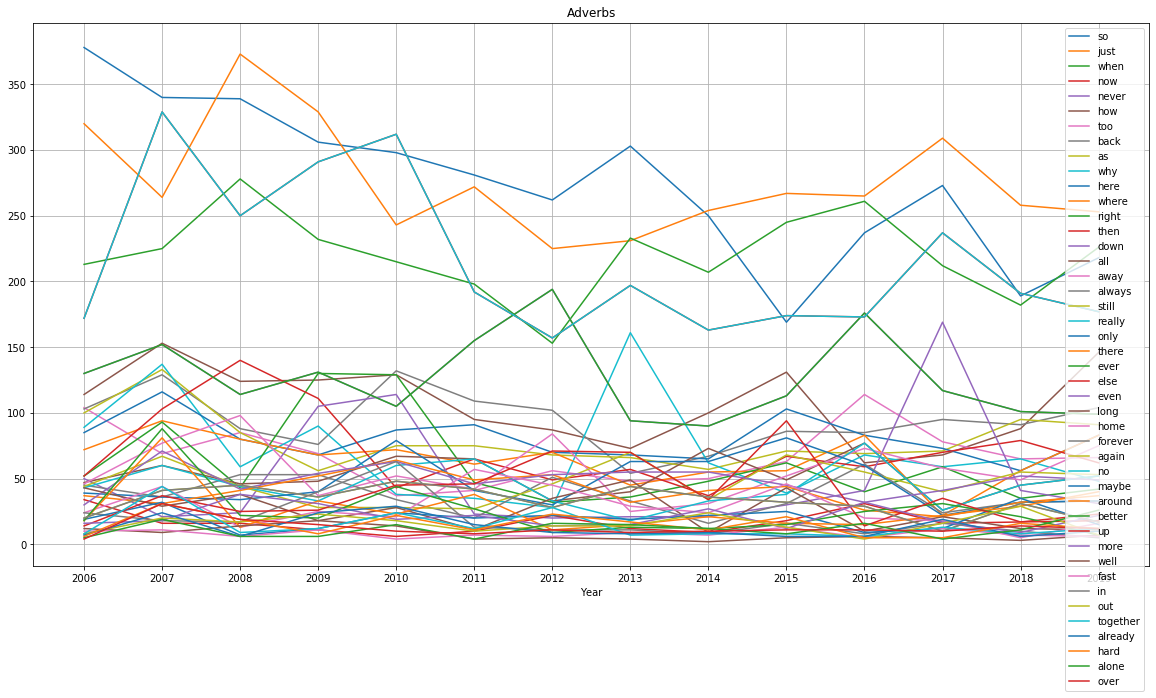

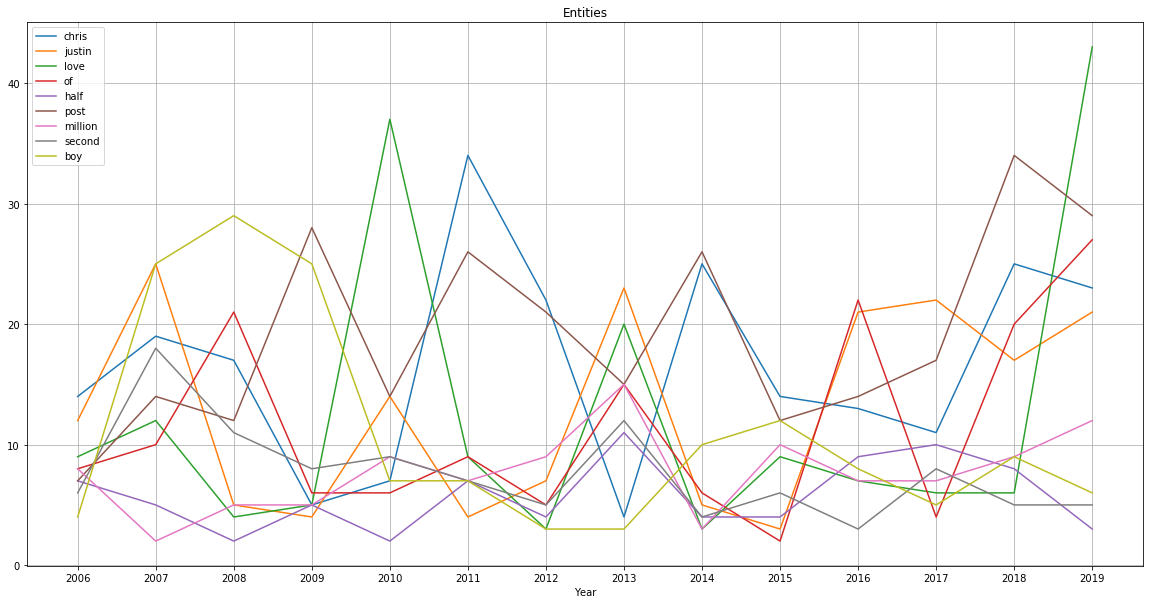

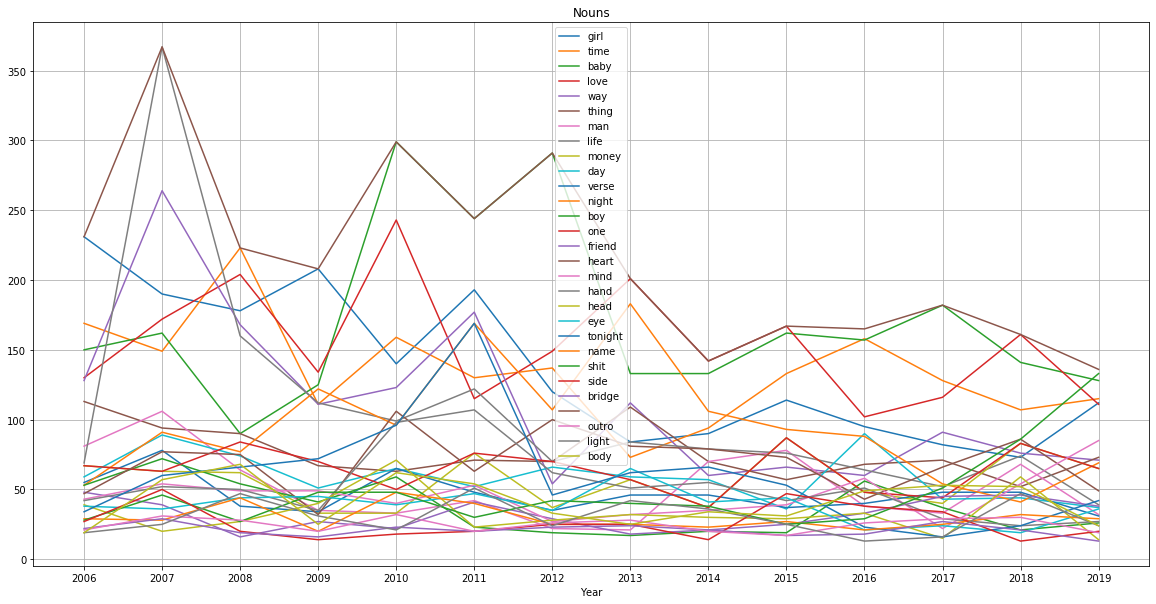

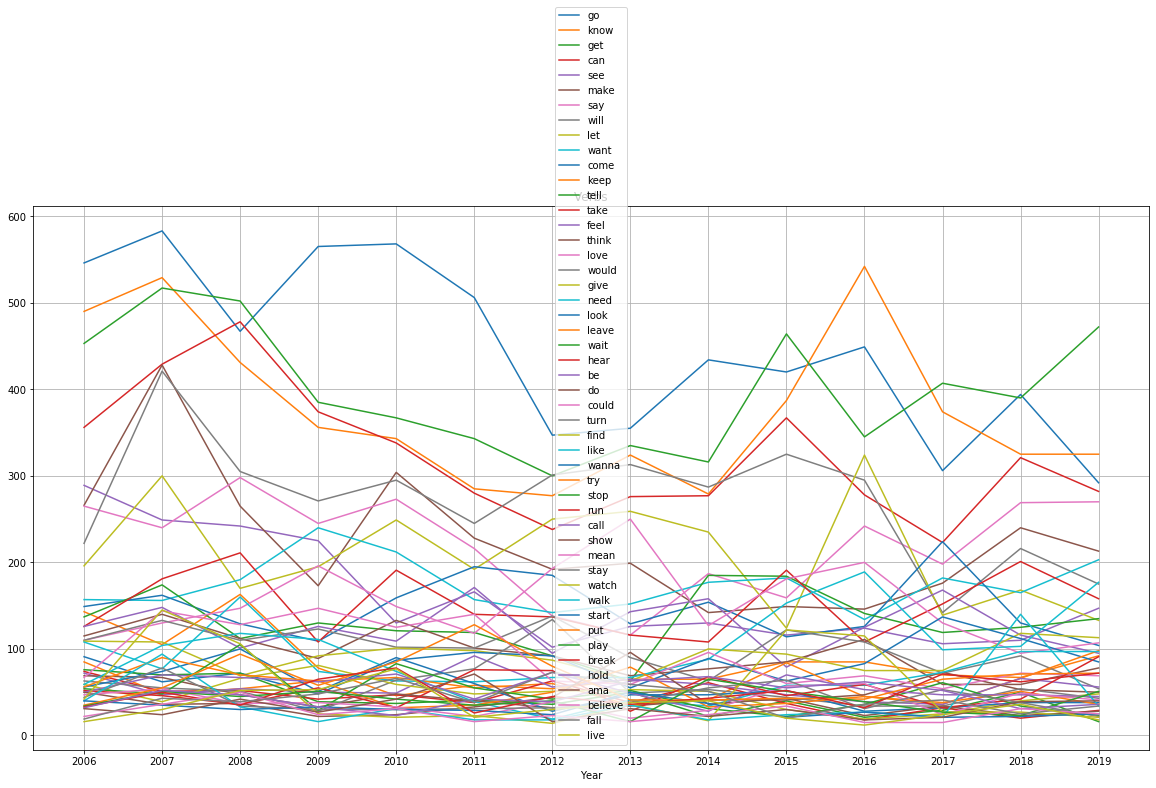

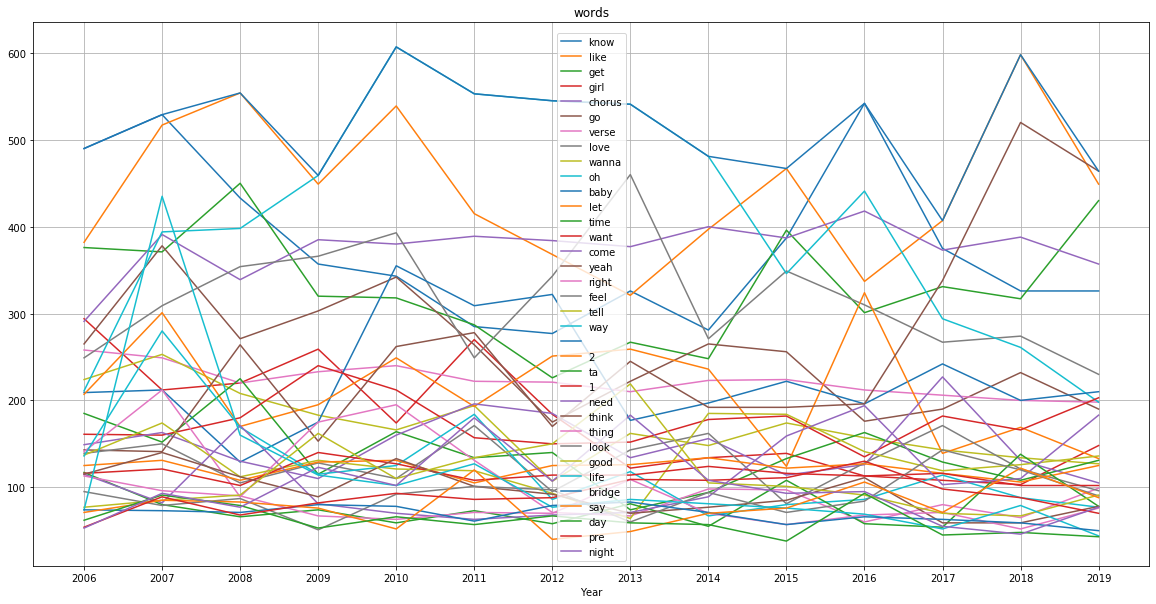

In [135]:
#5. graph popular terms by year.
all_adverbs_by_year.plot(figsize=(20, 10), title="Adverbs", grid="true", xticks=all_adverbs_by_year.index)
all_entities_by_year.plot(figsize=(20, 10), title="Entities", grid="true", xticks=all_entities_by_year.index)
all_nouns_by_year.plot(figsize=(20, 10), title="Nouns", grid="true", xticks=all_nouns_by_year.index)
all_verbs_by_year.plot(figsize=(20, 10), title="Verbs", grid="true", xticks=all_verbs_by_year.index)
all_words_by_year.plot(figsize=(20, 10), title="words", grid="true", xticks=all_words_by_year.index)

In [ ]:
#testing
# ti =5 #3 = humble 5 = bad and boujee
# song = genius_spacy_data.iloc[ti]
# lyrics = song['Lyrics']
# lyrics_contr = expand_contractions(lyrics)
# doc = nlp(lyrics_contr)
# cleaned = remove_adlibs(lyrics_contr)
# print (cleaned)


In [ ]:
#testing
# doc = nlp("i want to get this back as a string")
# print(str(doc))
# assert str(doc) == "i want to get this back as a string"